In [1]:
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

In [2]:
##Environment
class GridWorld:
    def __init__(self, height = 50, width = 50, n_c = 1, n_o = 1):
        self.wd = width
        self.ht = height
        self.n_c = n_c            # no. of classes
        self.n_o = n_o            # no. of objects  (n_c <= n_o)
        self.reward = [-1, 1]     # range of rewards
        self.start_coord = (0, 0)
        self.goal_coord = (height-1, width-1)
        self.x_g = height-1        # goal x-coord
        self.x_g = width-1         # goal y-coord
        self.r_g = 1               # goal reward
        self.D = 25 + n_o
        self.d = n_c + 1
        '''
        UP: 0
        RIGHT: 1
        DOWN: 2
        LEFT: 3
        '''
        self.actions = [0, 1, 2, 3]
        #self.x_s, self.y_s = self.start_coord

        self.object_coord = []
        self.object_class = []
        self.class_reward = {}
        self.objects_so_far = [0] * self.n_o

        self.generate_objects()    # Done once
        
        self.assign_classes()
        self.generate_class_reward()

    def generate_objects(self):
        n_o = self.n_o
        while n_o:
            object_x = np.random.randint(self.wd)
            object_y = np.random.randint(self.ht)
            if((object_x,object_y) not in self.object_coord):
                self.object_coord.append((object_x,object_y))
                n_o -= 1
  
    def assign_classes (self):
        self.object_class = np.random.randint(0, self.n_c, size = self.n_o)
 
    def generate_class_reward(self):
        for i in range(0, self.n_c):
            self.class_reward[i] = np.random.uniform(self.reward[0], self.reward[1])

    def reset(self):
        self.cur_pos_x, self.cur_pos_y = self.start_coord
        self.object_so_far = [0] * self.n_o
        self.generate_class_reward()
        return self.start_coord

    def render(self):
        for i in range(self.wd):
            for j in range(self.ht):
                if (i, j) in self.object_coord:
                    print(self.object_class[self.object_coord.index((i, j))], end = "")
                else:
                    print("*",end = "")
            print("")
            
    def show_class_rewards(self):
        print(self.class_reward)
    
    def restart(self):
        self.cur_pos_x, self.cur_pos_y = self.start_coord
        self.objects_so_far = [0] * self.n_o
        return self.start_coord
        
    def step(self, action):
        flag = 1
        reward = 0
        phi_at_step = [0] * (self.n_c + 1)
        done = False
        if action == 0 and self.cur_pos_y + 1 < self.ht:
            self.cur_pos_y += 1
        elif action == 1 and self.cur_pos_x + 1 < self.wd:
            self.cur_pos_x += 1
        elif action == 2 and self.cur_pos_y - 1 >=0:
            self.cur_pos_y -= 1
        elif action == 3 and self.cur_pos_x - 1 >=0:
            self.cur_pos_x -= 1
        
        pos = (self.cur_pos_x, self.cur_pos_y)
        if pos == self.goal_coord:
            phi_at_step[-1] = self.r_g
            done = True
            reward += 1
        elif pos in self.object_coord:
            object_index = self.object_coord.index(pos)
            if self.objects_so_far[object_index] == 0:
                phi_at_step[self.object_class[object_index]] = 1
                self.objects_so_far[object_index] = 1
                reward += self.class_reward[self.object_class[object_index]]

        return pos, np.array(phi_at_step), reward, done
               

In [3]:
class RadialBasis():

    def __init__(self, x_dim, y_dim, basis_x, basis_y):

        self.centres = []
        self.x_dim, self.y_dim = x_dim, y_dim
        for x in np.linspace(0, x_dim, basis_x):
            for y in np.linspace(0, y_dim, basis_y):
                self.centres.append((x/x_dim, y/y_dim))
      
    def getPositionVector(self, x, y):
        state = []
        x,y = x/self.x_dim, y/self.y_dim
        for cx, cy in self.centres:
            state.append(np.exp(-1 * ((cx - x)**2 + (cy - y)**2)/0.1))
        return np.array(state)

In [17]:
class SFQL:
    def __init__(self, env):
        self.env = env
        self.reward_weight_list = []
        self.Z_list = []
        self.eps_greedy = 0.15
        self.gamma = 0.9
        self.num_steps = 5000
        self.w_alpha = 0.01
        self.z_alpha = 0.01
        self.cum_reward_list = []
        self.rdb = RadialBasis(env.wd, env.ht, 5, 5)
        self.step_limit = 200
        
    def featurize_state(self, state):
        return np.hstack((self.rdb.getPositionVector(state[0], state[1]), np.array(self.env.objects_so_far)))
    
    def find_best_psi(self, w_t, small_phi):
        max_k = 0
        action_val = -999999
        action_val_his = -999999
        for k in range(0,len(self.Z_list)):
            for action in self.env.actions: 
                psi = np.dot(small_phi.T, self.Z_list[k][action])
                new_action_val = np.dot(psi.T,w_t)
                action_val = max(action_val,new_action_val)
            max_k = k if (action_val > action_val_his) else max_k
            action_val_his = action_val
        
        return max_k 
                
    def get_action(self, small_phi, c, w_t):
        if np.random.uniform(0,1) < self.eps_greedy:   #In paper, Bernoulli is considered imstead of uniform
            return np.random.choice(self.env.actions)
        else:
            val_his = -99999
            act_choice = 0
            for action in self.env.actions:
                psi = np.dot(small_phi.T, self.Z_list[c][action])
                val = np.dot(psi.T,w_t)
                act_choice = action if val > val_his else act_choice
                val_his = max(val_his,val)
            return act_choice

    def get_best_action(self, state, W):
        best_action, bqsa = 0, 0
        c = self.find_best_psi(W, state)
        for action in self.env.actions:
            qsa = np.dot(np.dot(state.T, self.Z_list[c][action]), W)
            if qsa > bqsa:
                bqsa = qsa
                best_action = action
        return best_action
        
    def test_task(self, W):
        state = self.env.restart()
        done = False
        steps = 0
        rewards = 0
        while not done and steps < self.step_limit:
            fstate = self.featurize_state(state)
            action = self.get_best_action(fstate, W)
            state, phi, reward, done = self.env.step(action)
            rewards += reward
            steps += 1
        #if not done:
        return rewards
        #return 0
    
    def test_all_tasks(self):
        cum_reward = 0
        for W in self.reward_weight_list:
            cum_reward += self.test_task(W)
        return cum_reward
        
    def algorithm(self, num_tasks):
        D = self.env.D
        d = self.env.d
        
        NUM_STEPS = self.num_steps
        
        #TODO: How to initialize the list? add before train or after train (only for the first task)
        
        Z = [np.random.rand(D,d)/20 for r in range(len(self.env.actions))]
        
        cr = [0]
        for t in range(0, num_tasks):
            print("Task: ",t)
        
            w_t = np.random.rand(d)/20
            #print("Z = ",Z)
            self.Z_list.append(deepcopy(Z))
            self.reward_weight_list.append(deepcopy(w_t))
            Z = self.Z_list[-1]
            w_t = self.reward_weight_list[-1]
            self.env.reset()

            #cum_reward = 0
            new_episode = True
            for ep in range(NUM_STEPS):
                if new_episode == True:
                    gamma = self.gamma
                    state = self.env.restart()
                    done = False
                    #creward = 0
                    new_episode = False
                
                small_phi = self.featurize_state(state)
                
                c = self.find_best_psi(w_t,small_phi)
                w_c = self.reward_weight_list[c]
                action = self.get_action(small_phi, c, w_t)
                s_prime, phi_at_step, reward, done = self.env.step(action)
                
                small_phi_prime = self.featurize_state(s_prime)

                if done:
                    gamma = 0
                    new_episode = True
                else:
                    c_prime = self.find_best_psi(w_t, small_phi_prime)
                    a_prime = self.get_action(small_phi_prime, c_prime, w_t)
                
                #cum_reward += reward
                #self.cum_reward_list.append(cum_reward)
                w_t = w_t + self.w_alpha * (reward - np.dot(phi_at_step.T, w_t)) * phi_at_step
                psi_prime = np.dot(small_phi_prime.T, self.Z_list[t][a_prime])
                psi = np.dot(small_phi.T, self.Z_list[t][action])
                z_t = self.Z_list[t][action]
                for k in range(0,d):
                    target_k = phi_at_step[k] + gamma*psi_prime[k]
                    z_t[:, k] = z_t[:, k] + self.z_alpha * (target_k - psi[k]) * small_phi

                if c != t:
                    a_prime = self.get_action(small_phi_prime, c, w_c)

                    psi_prime = np.dot(small_phi_prime.T, self.Z_list[c][a_prime])
                    psi = np.dot(small_phi.T, self.Z_list[c][action])
                    z_c = self.Z_list[c][action]
                    for k in range(0,d):
                        target_k = phi_at_step[k] + gamma*psi_prime[k]
                        z_c[:, k] = z_c[:, k] + self.z_alpha * (target_k - psi[k]) * small_phi_prime

                state = s_prime
                #print(round(cum_reward,4),end = " ")
            task_reward = self.test_task(w_t)
            cr += [cr[-1] + task_reward]
            print("Reward This Task", task_reward, "Cumulative Reward", cr[-1])
            #mavg += creward
            
            #print("Final",round(cum_reward,4))
        
        return cr
        #self.plot(cum_reward_list,num_tasks)
        #return self.cum_reward_list
    
    def plot(self,cum_reward_list,num_talks):
        x_size = self.num_steps * num_talks
        x_axis = list(range(1,x_size+1))
        y_axis = cum_reward_list
        plt.plot(x_axis,y_axis)
        plt.xlabel("steps")
        plt.ylabel("cumulative reward")
        plt.title("SFQL")
        plt.legend()
        plt.show()

In [78]:
env = GridWorld(10, 10, 3, 10)
a = SFQL(env)
cr = a.algorithm(250)

Task:  0
Reward This Task 0.5474477722461113 Cumulative Reward 0.5474477722461113
Task:  1
Reward This Task 0.5605108056948545 Cumulative Reward 1.1079585779409657
Task:  2
Reward This Task 1.3480497806254745 Cumulative Reward 2.4560083585664403
Task:  3
Reward This Task 2.7582657324330446 Cumulative Reward 5.214274090999485
Task:  4
Reward This Task 1.339719745590465 Cumulative Reward 6.5539938365899495
Task:  5
Reward This Task 1 Cumulative Reward 7.5539938365899495
Task:  6
Reward This Task 1.0684902104704739 Cumulative Reward 8.622484047060423
Task:  7
Reward This Task 0.8355978961642623 Cumulative Reward 9.458081943224686
Task:  8
Reward This Task 1 Cumulative Reward 10.458081943224686
Task:  9
Reward This Task 0.9835668744254993 Cumulative Reward 11.441648817650185
Task:  10
Reward This Task 0.9291037095368937 Cumulative Reward 12.37075252718708
Task:  11
Reward This Task 1.8240771872828252 Cumulative Reward 14.194829714469904
Task:  12
Reward This Task 1.7964516669518398 Cumulat

Reward This Task 2.7543279416497053 Cumulative Reward 144.15496979486386
Task:  104
Reward This Task 0.31875538677914506 Cumulative Reward 144.473725181643
Task:  105
Reward This Task 1.4640565130155776 Cumulative Reward 145.93778169465858
Task:  106
Reward This Task 2.014265918347654 Cumulative Reward 147.95204761300624
Task:  107
Reward This Task 1 Cumulative Reward 148.95204761300624
Task:  108
Reward This Task 1.9300848499705516 Cumulative Reward 150.88213246297678
Task:  109
Reward This Task 0.23500845556942118 Cumulative Reward 151.1171409185462
Task:  110
Reward This Task 2.4987632911350763 Cumulative Reward 153.61590420968128
Task:  111
Reward This Task 1.364085716328565 Cumulative Reward 154.97998992600984
Task:  112
Reward This Task 1.8420499261587477 Cumulative Reward 156.8220398521686
Task:  113
Reward This Task 0.7552658278897431 Cumulative Reward 157.57730568005832
Task:  114
Reward This Task 2.821635040794331 Cumulative Reward 160.39894072085264
Task:  115
Reward This Ta

Reward This Task -0.2568634745797347 Cumulative Reward 306.9067064789813
Task:  205
Reward This Task 1.0113893794142197 Cumulative Reward 307.9180958583955
Task:  206
Reward This Task 2.7602493349148727 Cumulative Reward 310.67834519331035
Task:  207
Reward This Task 1 Cumulative Reward 311.67834519331035
Task:  208
Reward This Task 1.3503821271301097 Cumulative Reward 313.02872732044045
Task:  209
Reward This Task 2.614233197740348 Cumulative Reward 315.6429605181808
Task:  210
Reward This Task 2.5080942754749413 Cumulative Reward 318.15105479365576
Task:  211
Reward This Task 0.8713213653528862 Cumulative Reward 319.0223761590087
Task:  212
Reward This Task 2.9279304018152006 Cumulative Reward 321.9503065608239
Task:  213
Reward This Task 1 Cumulative Reward 322.9503065608239
Task:  214
Reward This Task 2.8859783993341988 Cumulative Reward 325.8362849601581
Task:  215
Reward This Task 1.2708098938722556 Cumulative Reward 327.1070948540303
Task:  216
Reward This Task 1.917270272727227

In [18]:
env2 = GridWorld(10, 10, 3, 10)
b = SFQL(env2)
cr2 = b.algorithm(100)

Task:  0
Reward This Task 0 Cumulative Reward 0
Task:  1
Reward This Task 1.5914317249332512 Cumulative Reward 1.5914317249332512
Task:  2
Reward This Task 1.9405321118132761 Cumulative Reward 3.5319638367465274
Task:  3
Reward This Task 1.5351813716587395 Cumulative Reward 5.067145208405266
Task:  4
Reward This Task 1 Cumulative Reward 6.067145208405266
Task:  5
Reward This Task 1.9635522784510129 Cumulative Reward 8.03069748685628
Task:  6
Reward This Task 1 Cumulative Reward 9.03069748685628
Task:  7
Reward This Task 1.5405808237024932 Cumulative Reward 10.571278310558773
Task:  8
Reward This Task 0.6687138547630669 Cumulative Reward 11.23999216532184
Task:  9
Reward This Task 1 Cumulative Reward 12.23999216532184
Task:  10
Reward This Task 1 Cumulative Reward 13.23999216532184
Task:  11
Reward This Task 1 Cumulative Reward 14.23999216532184
Task:  12
Reward This Task 1.8570685237207245 Cumulative Reward 16.097060689042564
Task:  13
Reward This Task 1.3643410683310149 Cumulative Rew

In [19]:
cr2

[0,
 0,
 1.5914317249332512,
 3.5319638367465274,
 5.067145208405266,
 6.067145208405266,
 8.03069748685628,
 9.03069748685628,
 10.571278310558773,
 11.23999216532184,
 12.23999216532184,
 13.23999216532184,
 14.23999216532184,
 16.097060689042564,
 17.46140175737358,
 20.369251190336975,
 22.272582579001746,
 23.272582579001746,
 23.89854016647334,
 24.902716682314637,
 27.040766548929362,
 31.113679057063045,
 32.009116329517504,
 33.45039873123044,
 34.81122751391673,
 37.59609566774193,
 41.17687689369918,
 44.49357321673226,
 45.49357321673226,
 46.9457934803098,
 50.975299612927174,
 52.33159471037163,
 53.33159471037163,
 53.91148657918728,
 54.86351000825634,
 56.624849237042945,
 58.3898818105709,
 60.04894135764934,
 61.92090595074461,
 62.850170529440526,
 63.850170529440526,
 64.85017052944053,
 65.98705194342898,
 67.14428429457077,
 68.70007768773169,
 71.67091530015558,
 76.379887273168,
 78.72211812620235,
 79.69992785182896,
 84.40561272724571,
 86.5111917284703,
 91.

In [ ]:
file = open('cum_reward_list', 'wb')
pickle.dump(cum_reward_list, file)
file.close()

No handles with labels found to put in legend.


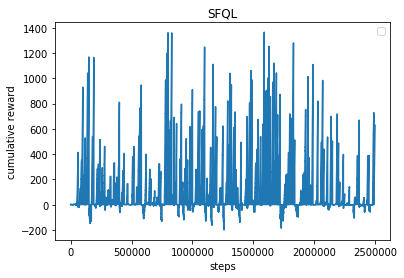

In [11]:
a.plot(a.cum_reward_list,250)

In [49]:
class QL:
    def __init__(self, env):
        self.env = env
        self.reward_weight_list = []
        self.z_list = []
        self.eps_greedy = 0.15
        self.gamma = 0.9
        self.num_steps = 40000
        self.alpha = 0.01
        self.rdb = RadialBasis(env.wd, env.ht, 5, 5)
        self.cum_reward_list = []
        self.step_limit = 200

    def featurize_state(self, state):
        return np.hstack((self.rdb.getPositionVector(state[0], state[1]), np.array(self.env.objects_so_far)))
    
    def find_q_val(self, small_phi, z):
        max_k = 0
        action_val = -999999    
        for action in self.env.actions: 
            new_action_val = np.dot(small_phi.T,z[action])
            action_val = max(action_val,new_action_val)
        
        return action_val
        
        
        return max_k 
                
    def get_action(self, small_phi, z):
        if np.random.uniform(0,1) < self.eps_greedy:   #In paper, Bernoulli is considered imstead of uniform
            return np.random.choice(self.env.actions)
        else:
            val_his = -99999
            act_choice = 0
            for action in self.env.actions:
                val = np.dot(small_phi.T, z[action])
                act_choice = action if val > val_his else act_choice
                val_his = max(val_his,val)
            return act_choice

    def get_best_action(self, state, z):
        val_his = -99999
        act_choice = 0
        for action in self.env.actions:
            val = np.dot(state.T, z[action])
            act_choice = action if val > val_his else act_choice
            val_his = max(val_his,val)
        return act_choice
        
    def test_task(self, Z):
        state = self.env.restart()
        done = False
        steps = 0
        rewards = 0
        while not done and steps < self.step_limit:
            fstate = self.featurize_state(state)
            action = self.get_best_action(fstate, Z)
            state, phi, reward, done = self.env.step(action)
            rewards += reward
            steps += 1
        #if not done:
        return rewards
    
    def algorithm(self,num_tasks):
        D = self.env.D
        d = self.env.d
        
        NUM_STEPS = self.num_steps
        cr = [0]
        
        for t in range(0, num_tasks):
            z = [np.random.rand(D)/20 for r in range(len(self.env.actions))]
            print("Task: ",t)
            #self.z_list.append(deepcopy(z))
            self.env.reset()

            #cum_reward = 0
            new_episode = True
            for ep in range(NUM_STEPS):
                if new_episode == True:
                    gamma = self.gamma
                    state = self.env.restart()
                    done = False
                    #creward = 0
                    new_episode = False
                
                small_phi = self.featurize_state(state)
                
                action = self.get_action(small_phi, z)
                s_prime, phi_at_step, reward, done = self.env.step(action)

                
                small_phi_prime = self.featurize_state(s_prime)

                if done:
                    gamma = 0
                    new_episode = True
               
                
                #cum_reward += reward
                #self.cum_reward_list.append(cum_reward)
                
                #z[action] = z[action] + self.alpha * (reward - np.dot(phi_at_step.T, w_t)) * phi_at_step
                q_prime_sa = self.find_q_val(small_phi_prime.T, z)
                q_sa = np.dot(small_phi.T, z[action])
                z_a = z[action]
               
                target = reward + gamma * q_prime_sa
                z_a = z_a + self.alpha * (target  - q_sa) * small_phi


                state = s_prime
                #print(round(cum_reward,4),end = " ")
            
            #mavg += creward
            #print("Final",round(cum_reward,4))
            test_reward = self.test_task(z)
            cr += [cr[-1] + test_reward]
            print("Current Reward", test_reward, "Cumulative Reward", cr[-1])
        #self.plot(cum_reward_list,num_tasks)
        return cr
    
    def plot(self,cum_reward_list,num_talks):
        x_size = self.num_steps * num_talks
        x_axis = list(range(1,x_size+1))
        y_axis = cum_reward_list
        plt.plot(x_axis,y_axis)
        plt.xlabel("steps")
        plt.ylabel("cumulative reward")
        plt.title("QL")
        plt.legend()
        plt.show()

In [53]:
cr3 = cr3[1:]

In [56]:
len(cr3)

100

In [48]:
ql = QL(env2)
cr3 = ql.algorithm(100)

Task:  0
Current Reward 0 Cumulative Reward 0
Task:  1
Current Reward 0.763493658164135 Cumulative Reward 0.763493658164135
Task:  2
Current Reward 0 Cumulative Reward 0.763493658164135
Task:  3
Current Reward 0 Cumulative Reward 0.763493658164135
Task:  4
Current Reward 0 Cumulative Reward 0.763493658164135
Task:  5
Current Reward 0 Cumulative Reward 0.763493658164135
Task:  6
Current Reward 0 Cumulative Reward 0.763493658164135
Task:  7
Current Reward 0 Cumulative Reward 0.763493658164135
Task:  8
Current Reward -0.9802005846015514 Cumulative Reward -0.2167069264374164
Task:  9
Current Reward 0 Cumulative Reward -0.2167069264374164
Task:  10
Current Reward 0 Cumulative Reward -0.2167069264374164
Task:  11
Current Reward 0 Cumulative Reward -0.2167069264374164
Task:  12
Current Reward 0 Cumulative Reward -0.2167069264374164
Task:  13
Current Reward 0 Cumulative Reward -0.2167069264374164
Task:  14
Current Reward 0 Cumulative Reward -0.2167069264374164
Task:  15
Current Reward 0 Cumula

In [71]:
cr1 = [0] + cr1

In [76]:
print(len(x), len(cr1), len(cr3))

101 100 100


In [50]:
ql2 = QL(env2)
cr4 = ql.algorithm(100)

Task:  0
Current Reward -0.047862902806415475 Cumulative Reward -0.047862902806415475
Task:  1
Current Reward 0 Cumulative Reward -0.047862902806415475
Task:  2
Current Reward 0 Cumulative Reward -0.047862902806415475
Task:  3
Current Reward 0 Cumulative Reward -0.047862902806415475
Task:  4
Current Reward 0 Cumulative Reward -0.047862902806415475
Task:  5
Current Reward 0 Cumulative Reward -0.047862902806415475
Task:  6
Current Reward 0.9996394574572061 Cumulative Reward 0.9517765546507906
Task:  7
Current Reward 0 Cumulative Reward 0.9517765546507906
Task:  8
Current Reward 0 Cumulative Reward 0.9517765546507906
Task:  9
Current Reward 0 Cumulative Reward 0.9517765546507906
Task:  10
Current Reward 0 Cumulative Reward 0.9517765546507906
Task:  11
Current Reward 0 Cumulative Reward 0.9517765546507906
Task:  12
Current Reward 0 Cumulative Reward 0.9517765546507906
Task:  13
Current Reward 0 Cumulative Reward 0.9517765546507906
Task:  14
Current Reward 0 Cumulative Reward 0.951776554650

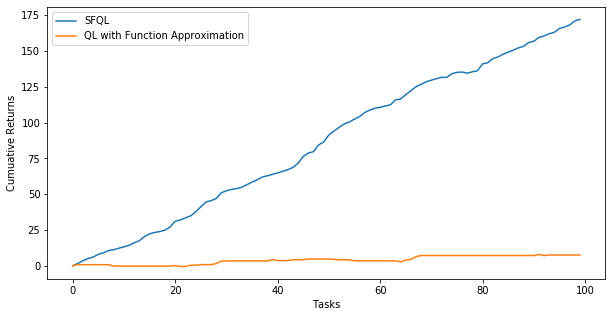

In [82]:
x = [i for i in range(100)]
plt.figure(figsize=(10,5))
plt.plot(x, cr1, label = "SFQL")
plt.plot(x, cr3, label = "QL with Function Approximation")
plt.xlabel("Tasks")
plt.ylabel("Cumuative Returns")
plt.legend()
plt.show()